# Lesson 7 | Road to the Top & Collaborative Filtering
> Convolutions, Pools, BatchNorm

> Checkout this notebook in [colab](https://colab.research.google.com/github/nglillywhite/blog/blob/main/posts/2023-03-08%20Fastai%20Lesson%208.ipynb)

## Book Content

This week, the lecture is mostly insane excels that show the same convolutions and filters that we work through in the book so there isn't 2 large sets of content to work through, I'll stick with just the book content. I highly recommend you checkout [the lecture](https://www.youtube.com/watch?v=htiNBPxcXgo) to see that absolute insanity that Jeremy is able to do in excel.

### Convolutional Neural Nets | CNNs

### What is a Convolution

A convolution is a the result of a *kernel* applied over an image/tensor/input. A kernel is a small matrix that acts like a sliding window over the inputs, the sum of the dot product of the kernel window on the tensor is then stored in the resulting tensor.

### Kernels

The kernel will have a few attributes, one is the size/shape of the windor, we're going to use a 3x3 matrix in this example, and a stride, which is by how many elements the window jumps between calculating the dot product. This will start to make more sense with some working examples but the important thing to know is the 'sliding window' effect and that you sum the dot product of the window on your input tensor.

Lets do a small example

In [ ]:
from fastai.vision.all import *

window = tensor([[-1,-1,-1],
                 [0 , 0, 0],
                 [1 , 1, 1]])

y = torch.randn(4,4)

The first kernel result would be the first 3x3 grid of the y tensor multiplied and summed as the first result. Our 'window' tensor will act as a kernel that we slide over our y tensor.

In [ ]:
y

tensor([[-0.4221, -0.1500,  0.0811, -0.7142],
        [ 0.1511, -1.0440,  1.8965, -0.0269],
        [ 0.1802,  2.7251, -0.2861,  0.7808],
        [ 0.9627, -0.3069,  0.2159,  1.3633]])

In [ ]:
y[0:3,0:3]

tensor([[-0.4221, -0.1500,  0.0811],
        [ 0.1511, -1.0440,  1.8965],
        [ 0.1802,  2.7251, -0.2861]])

In [ ]:
window

tensor([[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]])

In [ ]:
result = y[0:3,0:3] * window

result, result.sum()

(tensor([[ 0.4221,  0.1500, -0.0811],
         [ 0.0000, -0.0000,  0.0000],
         [ 0.1802,  2.7251, -0.2861]]),
 tensor(3.1101))

above is the result of our first kernel convolution and we would store this in the \[0,0\] location of our result tensor and slide the window across by the stride length (lets use 1 in this example) and run the calculation again, to be stored in the \[0,1\] location of our final tensor.

In [ ]:
y[0:3,1:4]

tensor([[-0.1500,  0.0811, -0.7142],
        [-1.0440,  1.8965, -0.0269],
        [ 2.7251, -0.2861,  0.7808]])

In [ ]:
result = y[0:3,1:4] * window
result, result.sum()

(tensor([[ 0.1500, -0.0811,  0.7142],
         [-0.0000,  0.0000, -0.0000],
         [ 2.7251, -0.2861,  0.7808]]),
 tensor(4.0029))

This is a random example however, lets move onto MNIST images which we covered in an earlier lesson without convolutions but our fastai implementation did implement under the hood, which we can now replicate.

<AxesSubplot: >

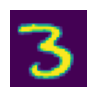

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

im3 = Image.open(path/'train/3/12.png')
show_image(im3)

So in order to run our kernel over the top of our image, we'd start with the top left and work our way striding over and down the image respectively, lets checkout what that first kernel result would look like

In [ ]:
im3_t = tensor(im3)
im3_t[0:3,0:3]

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.uint8)

Uh oh, our image is completely white in this top corner (0 being white, 255 being black). Lets look at a larger portion of our image and see if we can spot the top of this three

In [ ]:
df = pd.DataFrame(im3_t[4:10,2:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
2,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
3,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
4,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
5,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


Awesome, we've found the top chunk of the 3, lets now checkout the dot product and sum

In [ ]:
result = im3_t[4:7,6:9] * window

im3_t[4:7,6:9], result, result.sum()

(tensor([[  0,   0,   0],
         [142, 155, 246],
         [254, 254, 254]], dtype=torch.uint8),
 tensor([[  0,   0,   0],
         [  0,   0,   0],
         [254, 254, 254]]),
 tensor(762))

We can see that it zeroed out the middle row and then kept the lower row high valued which resulted in a high number when compared to an input tensor of zeroes or low values.

Lets make a small helper to allow us to apply the kernel over any range of elements more easily.

In [ ]:
def apply_kernel(row, col, kernel): return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [ ]:
apply_kernel(5,7,window)

tensor(762)

Great, we can replicate our previous result as well. Lets apply our kernel over the entire image and see what we get back

<AxesSubplot: >

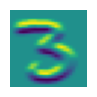

In [ ]:
space = range(1,27)

top = tensor([[apply_kernel(i,j,window) for j in space] for i in space])
show_image(top)

We can see the top horizontal edges (our -1,-1,-1 vector in our window kernel) are highlighted, whilst the bottom edges and vertical lines are dark and ignored respectively. Our window is a 'top edge' kernel/window

<AxesSubplot: >

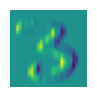

In [ ]:
left = tensor([[-1, 1, 0],
               [-1, 1, 0],
               [-1, 1, 0]]).float()

left_edge = tensor([[apply_kernel(i,j,left) for j in space] for i in space])
show_image(left_edge)

And the same logic is applied for the 'left' edge in the image, which have been highlighted. This [paper](https://arxiv.org/abs/1603.07285) has lots of awesome images to explain this better than I've written it (as well as the [fastai book](https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb) which mentions this particular paper.

### Pytorch Implementation

Being common calculations and widely used, pytorch has these types of functions built in within the `torch.nn.functional` library which we can simply call. The other awesome thing is that multiple kernels can be applied at the same time.

In [ ]:
diag1 = tensor([[ 0,-1,1],
                [-1, 1,0],
                [ 1, 0,0]])

diag2 = tensor([[1 ,-1,0],
                [0 , 1,0],
                [0 , 0,1]])

top = tensor([[1 ,-1,0],
              [0 , 1,0],
              [0 , 0,1]])

edge_kernels = torch.stack([left, top, diag1, diag2])
edge_kernels.shape

torch.Size([4, 3, 3])

The other fantastic thing is that pytorch will apply these kernels to multiple images at once, which means we can apply multiple kernels to multiple images in a single go. We can apply this to a whole mini-batch really easily, lets get a dataloader going.

In [ ]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

fastai by default loads up the GPU with your tensors, lets move this to the CPU since our `conv2d` gets calculated there by defaults (all will be explained in the next paragraph)

In [ ]:
xb,yb = to_cpu(xb), to_cpu(yb)

The above shape is a batch of 64 images, with one channel of a 28x28 pixel grid, Pytorch represents images as a rank-3 tensor, being `[channels, rows, columns]`.

`F.conv2d` which is our pytorch module which will run our kernels for us requires a rank-4 tensor (`[channels_in, features_out, rows, columns]`). Our `edge_kernels` doesn't have this shape at the moment and we need to tell pytorch we've only got 1 channel since we don't have a multi-colour image with the red,green, blue channels that you'd expect. 

We're going to insert a 'unit axis' which is an axis of size 1 in the first location to match the `channels_in` attribute, we can do this with the `unsqueeze` method. Unsqueeze places a 'unit axis' in the position that you give it, in our case we want to place it in the first position.

In [ ]:
edge_kernels.shape, edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [ ]:
torch.unsqueeze?

Docstring:
unsqueeze(input, dim) -> Tensor

Returns a new tensor with a dimension of size one inserted at the
specified position.

The returned tensor shares the same underlying data with this tensor.

A :attr:`dim` value within the range ``[-input.dim() - 1, input.dim() + 1)``
can be used. Negative :attr:`dim` will correspond to :meth:`unsqueeze`
applied at :attr:`dim` = ``dim + input.dim() + 1``.

Args:
    input (Tensor): the input tensor.
    dim (int): the index at which to insert the singleton dimension

Example::

    >>> x = torch.tensor([1, 2, 3, 4])
    >>> torch.unsqueeze(x, 0)
    tensor([[ 1,  2,  3,  4]])
    >>> torch.unsqueeze(x, 1)
    tensor([[ 1],
            [ 2],
            [ 3],
            [ 4]])
Type:      builtin_function_or_method


In [ ]:
edge_kernels.unsqueeze_(1)

tensor([[[[-1.,  1.,  0.],
          [-1.,  1.,  0.],
          [-1.,  1.,  0.]]],


        [[[ 1., -1.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  1.]]],


        [[[ 0., -1.,  1.],
          [-1.,  1.,  0.],
          [ 1.,  0.,  0.]]],


        [[[ 1., -1.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  1.]]]])

In [ ]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

This shape is a 64 image mini-batch, 4 kernels, and the 26x26 image. We lose a pixel on either side of the 28 pixel image because we can't slide our 3x3 kernel all the way to the edge

### Padding

Now since we've lost two pixels on either side, its probably not a huge deal in this particular context but its still a signal loss that we'd like to not have. We can pad the image to be wider than the original input so that we can